### Author: Ran Meng

This jupyter notebook contains my work for certification of "Extreme Gradient Boosting with XGBoost" instructed by Sergey Fogelson, from [DataCamp](https://app.datacamp.com/learn/courses/extreme-gradient-boosting-with-xgboost)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer

## Classification with XGBoost

#### XGBoost: Fit/Predict

It's time to create your first XGBoost model! As Sergey showed you in the video, you can use the scikit-learn .fit() / .predict() paradigm that you are already familiar to build your XGBoost models, as the xgboost library has a scikit-learn compatible API!

Here, you'll be working with churn data. This dataset contains imaginary data from a ride-sharing app with user behaviors over their first month of app usage in a set of imaginary cities as well as whether they used the service 5 months after sign-up. It has been pre-loaded for you into a DataFrame called churn_data - explore it in the Shell!

Your goal is to use the first month's worth of data to predict whether the app's users will remain users of the service at the 5 month mark. This is a typical setup for a churn prediction problem. To do this, you'll split the data into training and test sets, fit a small xgboost model on the training set, and evaluate its performance on the test set by computing its accuracy.

pandas and numpy have been imported as pd and np, and train_test_split has been imported from sklearn.model_selection. Additionally, the arrays for the features and the target have been created as X and y.

In [ ]:
# Create arrays for the features and the target: X, y
X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy)) # 0.758200

#### Decision trees
Your task in this exercise is to make a simple decision tree using scikit-learn's DecisionTreeClassifier on the breast cancer dataset that comes pre-loaded with scikit-learn.

This dataset contains numeric measurements of various dimensions of individual tumors (such as perimeter and texture) from breast biopsies and a single outcome value (the tumor is either malignant, or benign).

We've preloaded the dataset of samples (measurements) into X and the target values per tumor into y. Now, you have to split the complete dataset into training and testing sets, and then train a DecisionTreeClassifier. You'll specify a parameter called max_depth. Many other parameters can be modified within this model, and you can check all of them out [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

In [ ]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth = 4)

# Fit the classifier to the training set
dt_clf_4.fit(X_train, y_train)

# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy) # 0.9649122807017544

#### Measuring accuracy

You'll now practice using XGBoost's learning API through its baked in cross-validation capabilities. As Sergey discussed in the previous video, XGBoost gets its lauded performance and efficiency gains by utilizing its own optimized data structure for datasets called a DMatrix.

In the previous exercise, the input datasets were converted into DMatrix data on the fly, but when you use the xgboost cv object, you have to first explicitly convert your data into a DMatrix. So, that's what you will do here before running cross-validation on churn_data.

In [ ]:
# Create arrays for the features and the target: X, y
X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

             train-error-mean  train-error-std  test-error-mean  test-error-std
    0             0.282            0.002            0.284       1.932e-03
    1             0.270            0.002            0.272       1.932e-03
    2             0.256            0.003            0.258       3.963e-03
    3             0.251            0.002            0.254       3.827e-03
    4             0.247            0.002            0.249       9.344e-04

In [ ]:
# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1])) # 0.751480015401492

In [ ]:
'''#Nice work. cv_results stores the training and test mean and standard deviation of the error per boosting round (tree built) as a DataFrame. From cv_results, the final round 'test-error-mean' is extracted and converted into an accuracy, where accuracy is 1-error. The final accuracy of around 75% is an improvement from earlier!'''

#### Measuring AUC

Now that you've used cross-validation to compute average out-of-sample accuracy (after converting from an error), it's very easy to compute any other metric you might be interested in. All you have to do is pass it (or a list of metrics) in as an argument to the metrics parameter of xgb.cv().

Your job in this exercise is to compute another common metric used in binary classification - the area under the curve ("auc"). As before, churn_data is available in your workspace, along with the DMatrix churn_dmatrix and parameter dictionary params.

In [ ]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

           train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
    0           0.769      1.544e-03          0.768         0.003
    1           0.791      6.758e-03          0.789         0.007
    2           0.816      3.900e-03          0.814         0.006
    3           0.823      2.018e-03          0.822         0.004
    4           0.828      7.694e-04          0.826         0.002

In [ ]:
# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1]) # 0.8261911413597645

## Regression with XGBoost

#### Decision trees as base learners

It's now time to build an XGBoost model to predict house prices - not in Boston, Massachusetts, as you saw in the video, but in Ames, Iowa! This dataset of housing prices has been pre-loaded into a DataFrame called df. If you explore it in the Shell, you'll see that there are a variety of features about the house and its location in the city.

In this exercise, your goal is to use trees as base learners. By default, XGBoost uses trees as base learners, so you don't have to specify that you want to use trees here with booster="gbtree".

In [2]:
df = pd.read_csv('ames_housing_trimmed_processed.csv')

In [3]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [4]:
df.shape

(1460, 57)

In [5]:
X = df.loc[:, df.columns!='SalePrice']
print(X.shape)

y = df['SalePrice']

(1460, 56)


In [6]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 78847.401758


#### Linear base learners

Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train().

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in Chapter 1 when you used xgb.cv()). The key-value pair that defines the booster type (base model) you need is "booster":"gblinear".

Once you've created the model, you can use the .train() and .predict() methods of the model just like you've done in the past.

Here, the data has already been split into training and testing sets, so you can dive right into creating the DMatrix objects required by the XGBoost learning API.

In [7]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test =  xgb.DMatrix(data = X_test, label = y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:linear"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 44331.645061


#### Evaluating model quality

It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the Ames housing data. As in previous exercises, all necessary modules have been pre-loaded and the data is available in the DataFrame df.

In [8]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

In [9]:
# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

4    51348.279297
Name: test-rmse-mean, dtype: float64


Now, adapt your code to compute the "mae" instead of the "rmse".

In [10]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

In [11]:
# Extract and print final boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

4    35670.646484
Name: test-mae-mean, dtype: float64


#### Using regularization in XGBoost

Having seen an example of l1 regularization in the video, you'll now vary the l2 regularization penalty - also known as "lambda" - and see its effect on overall model performance on the Ames housing dataset.

In [12]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

#### Visualizing individual XGBoost trees

Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.

XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

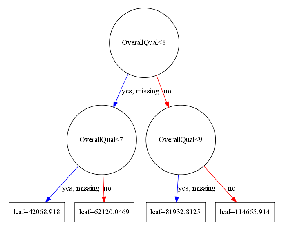

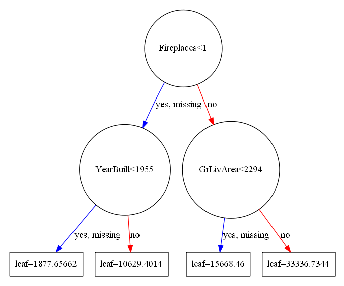

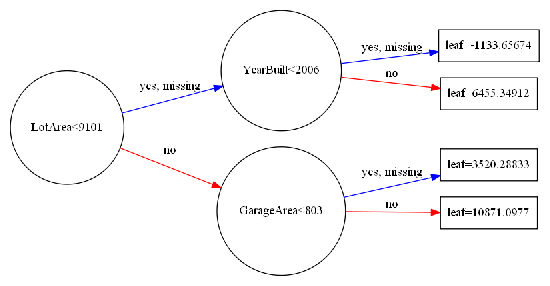

In [13]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees = 0)
plt.rcParams["figure.figsize"] = (15,5)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees = 4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees = 9, rankdir = 'LR')
plt.show()

#### Visualizing feature importances: What features are most important in my dataset

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this, and you'll get a chance to use it in this exercise!

[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

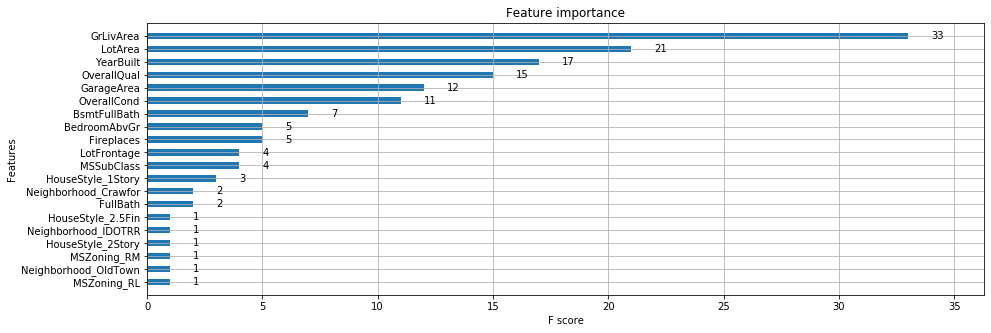

In [14]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data = X, label = y)

# Create the parameter dictionary: params
params = {'objective':'reg:linear', 'max_depth':4}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain = housing_dmatrix, num_boost_round = 10)

# Plot the feature importances
xgb.plot_importance(xg_reg, height = 0.5)
plt.rcParams["figure.figsize"] = (15,5)
plt.show()

## Fine-tuning your XGBoost model

#### Tuning the number of boosting rounds

Let's start with parameter tuning by seeing how the number of boosting rounds (number of trees you build) impacts the out-of-sample performance of your XGBoost model. You'll use xgb.cv() inside a for loop and build one model per num_boost_round parameter.

In [15]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data = X, label = y)

# Create the parameter dictionary for each tree: params 
params = {'objective': 'reg:linear', 'max_depth': 3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params= params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

#### Automated boosting round selection using early_stopping

Now, instead of attempting to cherry pick the best possible number of boosting rounds, you can very easily have XGBoost automatically select the number of boosting rounds for you within xgb.cv(). This is done using a technique called early stopping.

Early stopping works by testing the XGBoost model after every boosting round against a hold-out dataset and stopping the creation of additional boosting rounds (thereby finishing training of the model early) if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds. Here you will use the early_stopping_rounds parameter in xgb.cv() with a large possible number of boosting rounds (50). Bear in mind that if the holdout metric continuously improves up through when num_boost_rounds is reached, then early stopping does not occur.

Here, the DMatrix and parameter dictionary have been created for you. Your task is to use cross-validation with early stopping. Go for it!

In [16]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain = housing_dmatrix, params = params, nfold = 3, metrics = 'rmse', seed = 123, as_pandas = True, early_stopping_rounds = 10, num_boost_round = 50)

# Print cv_results
print(cv_results)

[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

#### Tuning eta (learning_rate)

It's time to practice tuning other XGBoost hyperparameters in earnest and observing their effect on model performance! You'll begin by tuning the "eta", also known as the learning rate.

The learning rate in XGBoost is a parameter that can range between 0 and 1, with higher values of "eta" penalizing feature weights more strongly, causing much stronger regularization.

In [17]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:linear", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:
    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain = housing_dmatrix, params = params, num_boost_round = 10, metrics = 'rmse', as_pandas = True, nfold = 3, early_stopping_rounds = 5, seed = 123)
        
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

#### Tuning max_depth

In this exercise, your job is to tune max_depth, which is the parameter that dictates the maximum depth that each tree in a boosting round can grow to. Smaller values will lead to shallower trees, and larger values to deeper trees.

In [18]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:linear", 'max_depth':20}

# Create list of max_depth values
max_depths = [2,5,10,20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:
    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain = housing_dmatrix, params = params, nfold = 2, early_stopping_rounds = 5, num_boost_round = 10, metrics = 'rmse', seed = 123, as_pandas = True)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

#### Tuning colsample_bytree

Now, it's time to tune "colsample_bytree". You've already seen this if you've ever worked with scikit-learn's RandomForestClassifier or RandomForestRegressor, where it just was called max_features. In both xgboost and sklearn, this parameter (although named differently) simply specifies the fraction of features to choose from at every split in a given tree. In xgboost, colsample_bytree must be specified as a float between 0 and 1.

In [19]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:linear","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params['colsample_bytree'] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_d

#### Grid search with XGBoost

Now that you've learned how to tune parameters individually with XGBoost, let's take your parameter tuning to the next level by using scikit-learn's GridSearch and RandomizedSearch capabilities with internal cross-validation using the GridSearchCV and RandomizedSearchCV functions. You will use these to find the best model exhaustively from a collection of possible parameter values across multiple parameters simultaneously. Let's get to work, starting with GridSearchCV!

In [20]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)


# Fit grid_mse to the data
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 5, 'n_estimators': 50}
Lowest RMSE found:  30342.16964561695


#### Random search with XGBoost

Often, GridSearchCV can be really time consuming, so in practice, you may want to use RandomizedSearchCV instead, as you will do in this exercise. The good news is you only have to make a few modifications to your GridSearchCV code to do RandomizedSearchCV. The key difference is you have to specify a param_distributions parameter instead of a param_grid parameter.

In [21]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions = gbm_param_grid, estimator = gbm, scoring = "neg_mean_squared_error", n_iter = 5, cv = 4, verbose = 1)

# Fit randomized_mse to the data
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 5}
Lowest RMSE found:  36636.35808132903


## Using XGBoost in pipelines

In [22]:
df = pd.read_csv('ames_unprocessed_data.csv')

In [23]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,PavedDrive,SalePrice
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,...,1710,1,0,2,1,3,0,548,Y,208500
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,...,1262,0,1,2,0,3,1,460,Y,181500
2,60,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2001,...,1786,1,0,2,1,3,1,608,Y,223500
3,70,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1915,...,1717,1,0,1,0,3,1,642,Y,140000
4,60,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000,...,2198,1,0,2,1,4,1,836,Y,250000


In [24]:
df.shape

(1460, 21)

#### Encoding categorical columns I: LabelEncoder

Now that you've seen what will need to be done to get the housing data ready for XGBoost, let's go through the process step-by-step.

First, you will need to fill in missing values - as you saw previously, the column LotFrontage has many missing values. Then, you will need to encode any categorical columns in the dataset using one-hot encoding so that they are encoded numerically. You can watch this video from Supervised Learning with scikit-learn for a refresher on the idea.

The data has five categorical columns: MSZoning, PavedDrive, Neighborhood, BldgType, and HouseStyle. Scikit-learn has a LabelEncoder function that converts the values in each categorical column into integers. You'll practice using this here.

In [25]:
# Fill missing values with 0
df.LotFrontage = df.LotFrontage.fillna(0)

# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

  MSZoning Neighborhood BldgType HouseStyle PavedDrive
0       RL      CollgCr     1Fam     2Story          Y
1       RL      Veenker     1Fam     1Story          Y
2       RL      CollgCr     1Fam     2Story          Y
3       RL      Crawfor     1Fam     2Story          Y
4       RL      NoRidge     1Fam     2Story          Y


In [26]:
# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())

   MSZoning  Neighborhood  BldgType  HouseStyle  PavedDrive
0         3             5         0           5           2
1         3            24         0           2           2
2         3             5         0           5           2
3         3             6         0           5           2
4         3            15         0           5           2


#### Encoding categorical columns II: OneHotEncoder

Okay - so you have your categorical columns encoded numerically. Can you now move onto using pipelines and XGBoost? Not yet! In the categorical columns of this dataset, there is no natural ordering between the entries. As an example: Using LabelEncoder, the CollgCr Neighborhood was encoded as 5, while the Veenker Neighborhood was encoded as 24, and Crawfor as 6. Is Veenker "greater" than Crawfor and CollgCr? No - and allowing the model to assume this natural ordering may result in poor performance.

As a result, there is another step needed: You have to apply a one-hot encoding to create binary, or "dummy" variables. 

In [27]:
categorical_columns

['MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle', 'PavedDrive']

In [28]:
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(sparse = False)

# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded
df_encoded = ohe.fit_transform(df)

# Print first 5 rows of the resulting dataset - again, this will no longer be a pandas dataframe
print(df_encoded[:5, :])

# Print the shape of the original DataFrame
print(df.shape)

# Print the shape of the transformed array
print(df_encoded.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1460, 21)
(1460, 3369)


#### Encoding categorical columns III: DictVectorizer

Alright, one final trick before you dive into pipelines. The two step process you just went through - LabelEncoder followed by OneHotEncoder - can be simplified by using a [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html).

Using a DictVectorizer on a DataFrame that has been converted to a dictionary allows you to get label encoding as well as one-hot encoding in one go.

In [29]:
df = pd.read_csv('ames_unprocessed_data.csv')

In [30]:
# Convert df into a dictionary: df_dict
df_dict = df.to_dict('records')

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse = False)

# Apply dv on df: df_encoded
df_encoded = dv.fit_transform(df_dict)

# Print the resulting first five rows
print(df_encoded[:5,:])

[[3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 2.000e+00 5.480e+02 1.710e+03 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  8.450e+03 6.500e+01 6.000e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 7.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.085e+05 2.003e+03]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 1.000e+00 2.000e+00 4.600e+02 1.262e+03 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.600e+03 8.000e+01 2.000e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 

In [31]:
# Print the vocabulary
print(dv.vocabulary_)

{'MSSubClass': 23, 'MSZoning=RL': 27, 'LotFrontage': 22, 'LotArea': 21, 'Neighborhood=CollgCr': 34, 'BldgType=1Fam': 1, 'HouseStyle=2Story': 18, 'OverallQual': 55, 'OverallCond': 54, 'YearBuilt': 61, 'Remodeled': 59, 'GrLivArea': 11, 'BsmtFullBath': 6, 'BsmtHalfBath': 7, 'FullBath': 9, 'HalfBath': 12, 'BedroomAbvGr': 0, 'Fireplaces': 8, 'GarageArea': 10, 'PavedDrive=Y': 58, 'SalePrice': 60, 'Neighborhood=Veenker': 53, 'HouseStyle=1Story': 15, 'Neighborhood=Crawfor': 35, 'Neighborhood=NoRidge': 44, 'Neighborhood=Mitchel': 40, 'HouseStyle=1.5Fin': 13, 'Neighborhood=Somerst': 50, 'Neighborhood=NWAmes': 43, 'MSZoning=RM': 28, 'Neighborhood=OldTown': 46, 'Neighborhood=BrkSide': 32, 'BldgType=2fmCon': 2, 'HouseStyle=1.5Unf': 14, 'Neighborhood=Sawyer': 48, 'Neighborhood=NridgHt': 45, 'Neighborhood=NAmes': 41, 'BldgType=Duplex': 3, 'Neighborhood=SawyerW': 49, 'Neighborhood=IDOTRR': 38, 'PavedDrive=N': 56, 'Neighborhood=MeadowV': 39, 'BldgType=TwnhsE': 5, 'MSZoning=C (all)': 24, 'Neighborhood=E

In [32]:
'''Besides simplifying the process into one step, DictVectorizer has useful attributes such as vocabulary_ which maps the names of the features to their indices. With the data preprocessed, it's time to move onto pipelines'''

"Besides simplifying the process into one step, DictVectorizer has useful attributes such as vocabulary_ which maps the names of the features to their indices. With the data preprocessed, it's time to move onto pipelines"

#### Preprocessing within a pipeline

Now that you've seen what steps need to be taken individually to properly process the Ames housing data, let's use the much cleaner and more succinct DictVectorizer approach and put it alongside an XGBoostRegressor inside of a scikit-learn pipeline.

In [33]:
X = df.loc[:, df.columns!='SalePrice']
print(X.shape)

y = df['SalePrice']

(1460, 20)


In [34]:
# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse = False)),
         ("xgb_model", xgb.XGBRegressor())]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Fit the pipeline
xgb_pipeline.fit(X.to_dict("records"), y)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Pipeline(steps=[('ohe_onestep', DictVectorizer(sparse=False)),
                ('xgb_model', XGBRegressor())])

#### Cross-validating your XGBoost model

In this exercise, you'll go one step further by using the pipeline you've created to preprocess and cross-validate your model.

In [35]:
# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor(max_depth=2, objective="reg:linear"))]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Cross-validate the model
cross_val_scores = cross_val_score(xgb_pipeline, X.to_dict("records"), y, scoring = "neg_mean_squared_error", cv = 10)

# Print the 10-fold RMSE
print("10-fold RMSE: ", np.mean(np.sqrt(np.abs(cross_val_scores))))

10-fold RMSE:  29867.603720688923


#### Kidney disease case study I: Categorical Imputer

You'll now continue your exploration of using pipelines with a dataset that requires significantly more wrangling. The chronic kidney disease dataset contains both categorical and numeric features, but contains lots of missing values. The goal here is to predict who has chronic kidney disease given various blood indicators as features.

As Sergey mentioned in the video, you'll be introduced to a new library, sklearn_pandas, that allows you to chain many more processing steps inside of a pipeline than are currently supported in scikit-learn. Specifically, you'll be able to use the DataFrameMapper() class to apply any arbitrary sklearn-compatible transformer on DataFrame columns, where the resulting output can be either a NumPy array or DataFrame.

We've also created a transformer called a Dictifier that encapsulates converting a DataFrame using .to_dict("records") without you having to do it explicitly (and so that it works in a pipeline). Finally, we've also provided the list of feature names in kidney_feature_names, the target name in kidney_target_name, the features in X, and the target in y.

In this exercise, your task is to apply sklearn's SimpleImputer to impute all of the categorical columns in the dataset. You can refer to how the numeric imputation mapper was created as a template. Notice the keyword arguments input_df=True and df_out=True? This is so that you can work with DataFrames instead of arrays. By default, the transformers are passed a numpy array of the selected columns as input, and as a result, the output of the DataFrame mapper is also an array. Scikit-learn transformers have historically been designed to work with numpy arrays, not pandas DataFrames, even though their basic indexing interfaces are similar.

In [36]:
kidney_disease_df = pd.read_csv('chronic_kidney_disease.csv')

In [37]:
kidney_disease_df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,pot,...,bu,sc,sod,htn,dm,cad,appet,pe,ane,class
0,48,80,1.02,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.02,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.01,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.01,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [38]:
kidney_disease_df.shape

(400, 25)

In [40]:
def transform_target(target):
    if target == 'ckd':
        return 1
    return 0

In [41]:
kidney_disease_df['target'] = kidney_disease_df.apply(lambda x:transform_target(x['class']), axis = 1)

In [42]:
kidney_disease_df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,pot,...,sc,sod,htn,dm,cad,appet,pe,ane,class,target
0,48,80,1.02,1,0,?,normal,notpresent,notpresent,121,...,7800,5.2,yes,yes,no,good,no,no,ckd,1
1,7,50,1.02,4,0,?,normal,notpresent,notpresent,?,...,6000,?,no,no,no,good,no,no,ckd,1
2,62,80,1.01,2,3,normal,normal,notpresent,notpresent,423,...,7500,?,no,yes,no,poor,no,yes,ckd,1
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,6700,3.9,yes,no,no,poor,yes,yes,ckd,1
4,51,80,1.01,2,0,normal,normal,notpresent,notpresent,106,...,7300,4.6,no,no,no,good,no,no,ckd,1


In [43]:
kidney_disease_df.tail()

,age,bp,sg,al,su,rbc,pc,pcc,ba,pot,...,sc,sod,htn,dm,cad,appet,pe,ane,class,target
395,55,80,1.02,0,0,normal,normal,notpresent,notpresent,140,...,6700,4.9,no,no,no,good,no,no,notckd,0
396,42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,...,7800,6.2,no,no,no,good,no,no,notckd,0
397,12,80,1.02,0,0,normal,normal,notpresent,notpresent,100,...,6600,5.4,no,no,no,good,no,no,notckd,0
398,17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,...,7200,5.9,no,no,no,good,no,no,notckd,0
399,58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,...,6800,6.1,no,no,no,good,no,no,notckd,0


In [44]:
kidney_disease_df = kidney_disease_df.replace('?', np.nan)

In [45]:
X = kidney_disease_df.loc[:, ~kidney_disease_df.columns.isin(['class', 'target'])]
y = kidney_disease_df['target']
print(X.shape)

(400, 24)


In [46]:
# Check number of nulls in each feature column
nulls_per_column = X.isnull().sum()
print(nulls_per_column)

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
pot       44
hemo      19
pcv       17
wc        87
rc        88
bgr       52
bu        71
sc       106
sod      131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64


In [47]:
X.dtypes

age      object
bp       object
sg       object
al       object
su       object
rbc      object
pc       object
pcc      object
ba       object
pot      object
hemo     object
pcv      object
wc       object
rc       object
bgr      object
bu       object
sc       object
sod      object
htn      object
dm       object
cad      object
appet    object
pe       object
ane      object
dtype: object

In [48]:
X['age'] = X.age.astype('float64')
X['bp'] = X.bp.astype('float64')
X['sg'] = X.sg.astype('float64')
X['al'] = X.al.astype('float64')
X['su'] = X.su.astype('float64')
X['pot'] = X.pot.astype('float64')
X['hemo'] = X.hemo.astype('float64')
X['pcv'] = X.pcv.astype('float64')
X['wc'] = X.wc.astype('float64')
X['rc'] = X.rc.astype('float64')
X['bgr'] = X.bgr.astype('float64')
X['bu'] = X.bu.astype('float64')
X['sc'] = X.sc.astype('float64')
X['sod'] = X.sod.astype('float64')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [49]:
X.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
pot      float64
hemo     float64
pcv      float64
wc       float64
rc       float64
bgr      float64
bu       float64
sc       float64
sod      float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object

In [50]:
# Create a boolean mask for categorical columns
categorical_feature_mask = X.dtypes == object

# Get list of categorical column names
categorical_columns = X.columns[categorical_feature_mask].tolist()
print(categorical_columns)

['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [51]:
# Get list of non-categorical column names
non_categorical_columns = X.columns[~categorical_feature_mask].tolist()
print(non_categorical_columns)

['age', 'bp', 'sg', 'al', 'su', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'bgr', 'bu', 'sc', 'sod']


In [52]:
# Apply numeric imputer
numeric_imputation_mapper = DataFrameMapper(
                                            [([numeric_feature],SimpleImputer(strategy="median")) for numeric_feature in non_categorical_columns],
                                            input_df=True,
                                            df_out=True
                                           )

In [53]:
# Apply categorical imputer
categorical_imputation_mapper = DataFrameMapper(
                                                [(categorical_columns, SimpleImputer(strategy='most_frequent'))],
                                                input_df=True,
                                                df_out=True
                                               )

#### Kidney disease case study II: Feature Union

Having separately imputed numeric as well as categorical columns, your task is now to use scikit-learn's FeatureUnion to concatenate their results, which are contained in two separate transformer objects - numeric_imputation_mapper, and categorical_imputation_mapper, respectively.

You may have already encountered FeatureUnion in [Machine Learning with the Experts: School Budgets](https://campus.datacamp.com/courses/case-study-school-budgeting-with-machine-learning-in-python/improving-your-model?ex=7). Just like with pipelines, you have to pass it a list of (string, transformer) tuples, where the first half of each tuple is the name of the transformer.

In [54]:
# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
                                          ("num_mapper", numeric_imputation_mapper),
                                          ("cat_mapper", categorical_imputation_mapper)
                                         ])

In [ ]:
# Create full pipeline
pipeline = Pipeline([
                     ("featureunion", numeric_categorical_union),
                     ("dictifier", Dictifier()),
                     ("vectorizer", DictVectorizer(sort = False)),
                     ("clf", xgb.XGBClassifier(max_depth = 3))
                    ])

# Perform cross-validation
cross_val_scores = cross_val_score(pipeline, X, y, scoring ="roc_auc", cv = 3)

# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores)) # 0.998237712755785

#### Bringing it all together

Alright, it's time to bring together everything you've learned so far! In this final exercise of the course, you will combine your work from the previous exercises into one end-to-end XGBoost pipeline to really cement your understanding of preprocessing and pipelines in XGBoost.

Your work from the previous 3 exercises, where you preprocessed the data and set up your pipeline, has been pre-loaded. Your job is to perform a randomized search and identify the best hyperparameters.

In [ ]:
# Create the parameter grid
gbm_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator = pipeline, param_distributions = gbm_param_grid, n_iter = 2, scoring = 'roc_auc', verbose = 1, cv = 2)

# Fit the estimator
randomized_roc_auc.fit(X, y)

# Compute metrics
print(randomized_roc_auc.best_score_) #     0.9965333333333333
# print(randomized_roc_auc.best_estimator_)